In [1]:
]activate calculations 

  Activating project at `~/spinGlasses/calculations`


# Setup

In [3]:
using calculations
using Revise
using Plots; gr()

using LaTeXStrings
using Statistics
using ColorSchemes

function norm(arr)
    arrNorm = sum(abs.(arr))
    arrNorm
end;

function coinflip()
    return 2*(rand()>0.5) - 1
end


coinflip (generic function with 1 method)

In [4]:
calculations.nPoints = 100;
calculations.nBonds = 100;
calculations.sigma = 3;

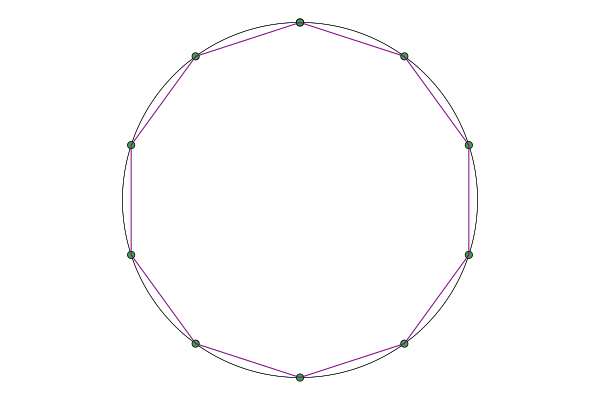

In [5]:
plot!(size=(750, 750))
calculations.nPoints = 10;
calculations.nBonds = 10;
calculations.sigma = 5.;

connectionsSet = calculations.generateConnectionSet();
connectionPlot = calculations.bigPlotFunction(connectionsSet); 

plot!(connectionPlot)

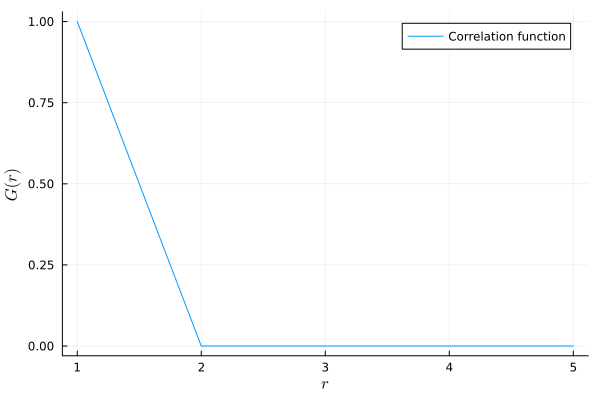

In [7]:
plot(calculations.correlationFunction(connectionsSet), label="Correlation function") #, yaxis = :log, xaxis=:log)
plot!(xlabel=L"r", ylabel=L"$G(r)$")

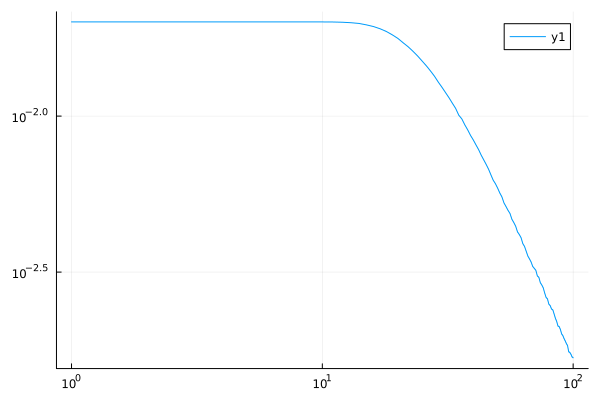

In [41]:
calculations.nPoints = 1000
calculations.nBonds = 49900
calculations.sigma = 1

y = calculations.correlationFunctionStatistics(100)

plot(y[1][1:100], ribbon=y[2][1:100]/2, yaxis=:log, xaxis=:log)

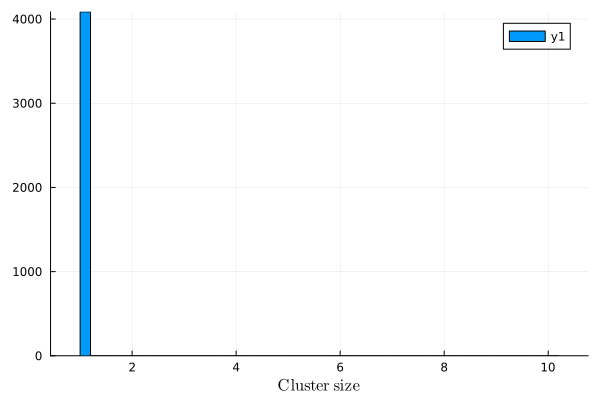

In [6]:
connectionArray = calculations.connectionSetToConnectivityArrayConversion(connectionsSet);
clusters = calculations.clusterIdentification(connectionArray);
clusterSizes = [];
for cluster in clusters
    push!(clusterSizes, length(cluster))
end

histogram(clusterSizes, xlabel=L"\textrm{Cluster\ size}")

### Cluster Size Distribution

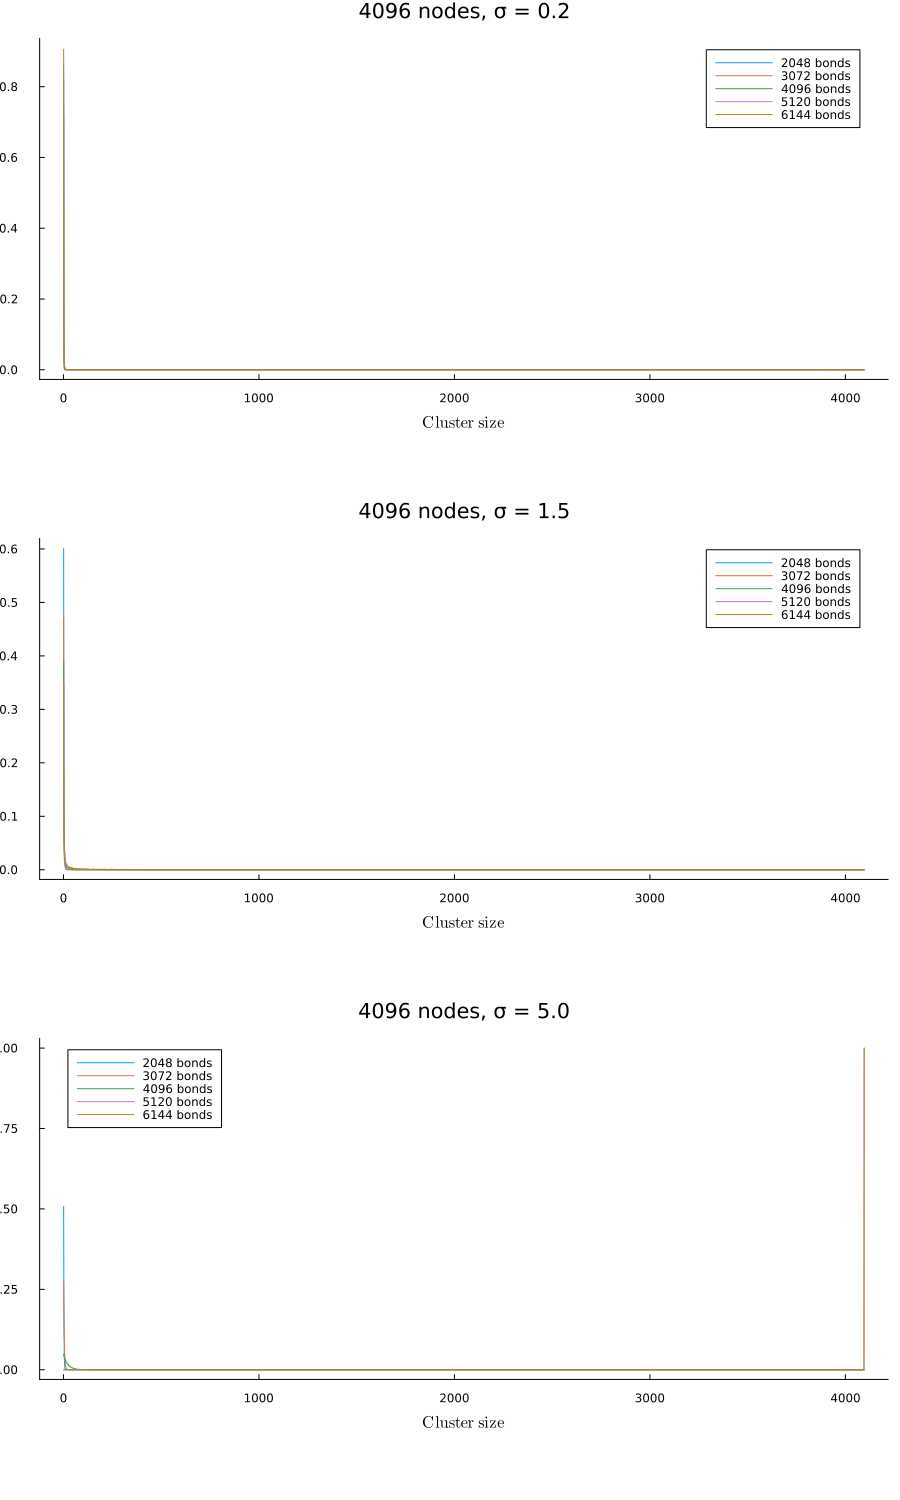

In [49]:
calculations.nPoints = 4096
nBondsArray = div(calculations.nPoints, 2) : div(calculations.nPoints, 4) : div(3 * calculations.nPoints, 2)
sigmaArray = [0.2 , 1.5, 5]

clusterSizes = range(sqrt(nPoints), nPoints, length=nPoints)

plt = plot(layout = (length(sigmaArray),1), size=(900, 1500), bottom_margin=15Plots.mm, legend=false, grid=false)# , ylims=(0,0.5))

for (index, sigma) in enumerate(sigmaArray)
    calculations.sigma = sigma
    
    meanNClusters = []
    varNClusters = []

    plot!(title="$(calculations.nPoints) nodes, σ = $(calculations.sigma)", sp=index)
    
    for nbonds in nBondsArray
        calculations.nBonds = nbonds
        y = calculations.clusterSizeStatistics(100)
        yNorm = norm(y[1])
        
        y = y ./ yNorm
         
        plot!(y[1], ribbon=y[2]/2  , label="$(calculations.nBonds) bonds", sp=index)

        plot!(legendcols=length(nBondsArray))
    end

plot!(xlabel=L"\textrm{Cluster\ size}", sp=index, legend=true)

end

plot!()

#savefig("figures/clusterSizeDistribution.pdf")

### Number of clusters

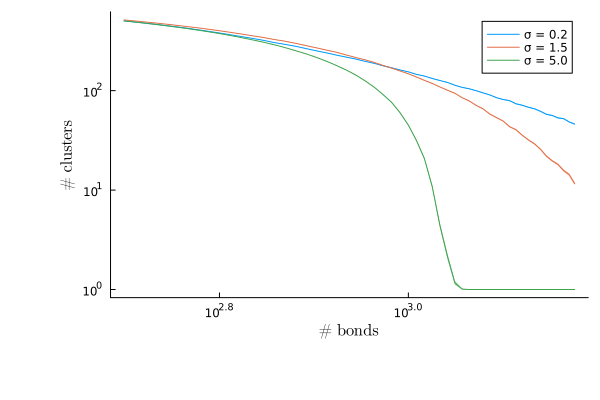

In [47]:
calculations.nPoints = 1000
plt = plot(left_margin=15Plots.mm,bottom_margin=15Plots.mm, legend=false, grid=false)

nBondsArray = 500:20:1500
sigmaArray = [0.2, 1.5, 5]

for (index, sigma) in enumerate(sigmaArray)
        
    meanNClusters = []
    varNClusters = []
    
    calculations.sigma = sigma
    
    for nBonds in nBondsArray
        calculations.nBonds = nBonds
        nClusters = calculations.clusterCountStatistics(100)
        append!(meanNClusters, nClusters[1])
        append!(varNClusters, nClusters[2])
    end
    plot!(nBondsArray, meanNClusters, ribbon=varNClusters, label="σ = $(calculations.sigma)")
end

plot!(xlabel=L"\textrm{\#\ bonds}", ylabel=L"\textrm{\#\ clusters}",legend=true)

plot!(xaxis=:log, yaxis=:log)

# savefig("figures/nClusters.pdf")
plot!()

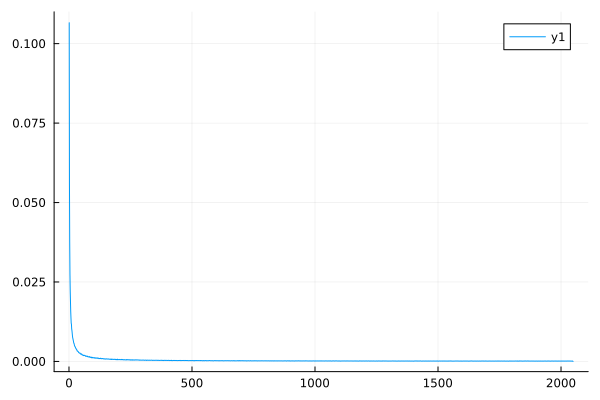

In [49]:
calculations.sigma = 0
calculations.nPoints = 4096
calculations.nBonds = 4096
y = calculations.correlationFunctionStatistics(100)

plot(y[1], ribbon=y[2]/2)
plot!()

## Metropolis

In [50]:
calculations.sigma = 10

spins = [ coinflip() for _ in 1:nPoints ]

connectionsSet = calculations.generateConnectionSet()
p = plot()


@gif for frame in 1:1000
    bar(p, spins, show=true, legend=false, title="Frame $frame")
    global spins = calculations.metropolis.singleStep(nPoints,T, connectionsArray, spins)
end

LoadError: BoundsError: attempt to access 1000-element Vector{Vector{Any}} at index [1777]

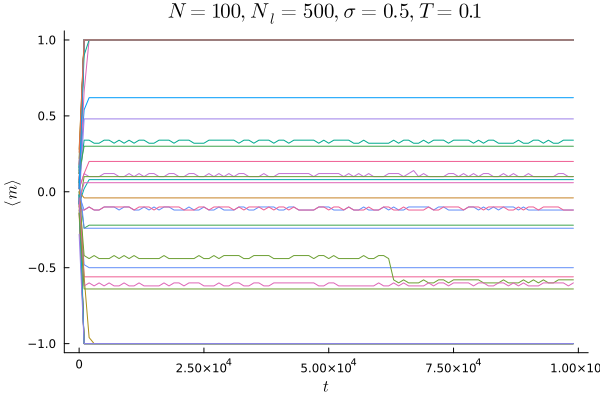

In [78]:
calculations.sigma = .5
calculations.nPoints = 100
calculations.nBonds = 500


T = 0.1
flips = 100000
nCurves = 50

summ2 = 0
downsizeFactor = 1000

m = [ [ ] for curve in 1:nCurves]


p = plot(layout=(1, 1), grid=false)

for curve in 1:nCurves
    connectionsSet = calculations.generateConnectionSet()
connectionsArray = calculations.connectionSetToConnectivityArrayConversion(connectionsSet)

    spins = [ coinflip() for _ in 1:nPoints ]
    
    global flipsPlot
    flipsPlot = []

    for flip in 1:flips
        
        spins = calculations.metropolis.singleStep(nPoints, T, connectionsArray, spins)
        
        if flip%downsizeFactor == 1 # So that it starts at 1
            append!(flipsPlot, flip)
            append!(m[curve], sum(spins) / nPoints)
        end
    end

  
end
  plot!(p, flipsPlot, m, 
        legend=false, xlabel=L"t", ylabel=L"\langle m \rangle")
plot!(p, title = L"N = %$(calculations.nPoints), N_l = %$(calculations.nBonds), \sigma = %$(calculations.sigma), T = %$T")
#plot!(p, m2./nCurves, sp=2)
savefig("figures/magnetization.pdf")
plot!()

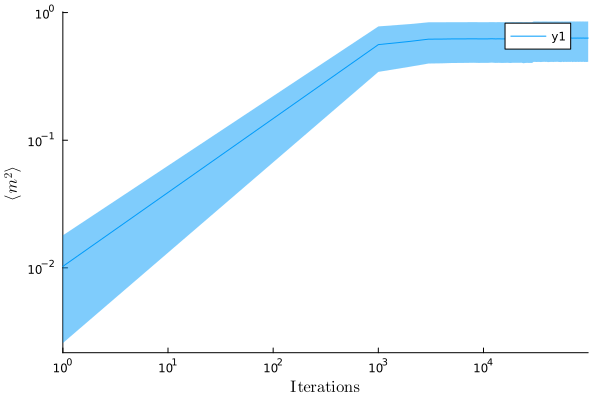

In [72]:
plot( xaxis=:log, yaxis=:log, grid=false)

plot!(xlims = (1, flipsPlot[end]))
m2Mean = [ 0. for _ in m[1] ]
m2STD = [ 0. for _ in m[1] ]

for flip in 1:length(m[1])
    mean = 0.
    std = 0.
    for curve in m
        mean += curve[flip] ^ 2
    end
    mean /= nCurves

    for curve in m
        std += (curve[flip]^2 - mean) ^2
    end
    std = sqrt(std / nCurves)
    m2Mean[flip] = mean
    m2STD[flip] = std
end

plot!(flipsPlot, m2Mean, ribbon=m2STD/2, grid=false)
#plot!(flips, 10^-5.5*flips .^ 1.7, sp=1, legend=false)
plot!(xlabel=L"\textrm{Iterations}", ylabel=L"\langle m ^2 \rangle")

#savefig("figures/magnetization2.pdf")

plot!()